## Sunspot Models
## Author: Mark Cheung (github @fluxtransport)

### In this notebook, we develop a axisymmetric model of the magnetic field structure of a sunspot. 


In [445]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy import init_printing
init_printing(use_unicode=True)
import numpy as np

In [413]:
# Curl operator in cylindrical coordinates
def curl(V, x):
    from sympy import diff
    curlV = (diff(V[2], x[1])/x[0]  - diff(V[1],x[2]),
             diff(V[0], x[2]) - diff(V[2], x[0]),
             (diff(x[0]*V[1], x[0]) - diff(V[0], x[1]))/x[0]
            )
    return curlV

def AxB(A, B):
    return ((A[1]*B[2]-A[2]*B[1]),
            (A[2]*B[0]-A[0]*B[2]),
            (A[0]*B[1]-A[1]*B[0]))

### Schlüter & Temesvàry ([1958]( https://articles.adsabs.harvard.edu/pdf/1958IAUS....6..263S )) sought to obtain a magnetohydrostatic equilibrium solution to sunspot structure. They made the following assumptions.

A1. Cylindrical symmetry ($r$ is radial distance from axis of symmetry, $\theta$ is azimuth, $z$ is depth): $j_z(r=0) = B_r(r=0)=0$. 

A2. Time-independent solution: $\partial / \partial t = 0$

A3. $\vec{B}, $and derivatives$ \to 0$ as $r \to \infty$ and $z \to -\infty$

B1. Plasma velocity inside spot $v=0$

B2. $B_\theta = 0$ everywhere, so that magnetic field lines lie on $r-z$ planes at fixed $\theta$.

B3. Assume relative cross-sectional profile is everywhere geometrically similar. 

In [491]:
# Define sympy symbols and functions
r, theta, z, zeta = sp.symbols('r theta z zeta')
r1 = sp.symbols('r1') # need a dummy variable to calculate the flux function
R = sp.Function('R')(z)


# Define height profiles Hp and zeta change everything. 
Hp = 2+(-z)/2 # Mm
zeta = sp.exp(-z/Hp)

B0 = 4000.*(zeta*zeta) # Bz component at axis r=0, in Gauss
R0 = 8 # effective radius of flux tube at z=0, in Mm
R = R0/(zeta) # Effective radius of flux tube as a function of zeta (and of depth z)

# Magnetic field profiles
Bz = B0*sp.exp(-r*r/(R*R)) # Vertical component, + means downward
Bt = 0 #Azimuthal component, zero
# Assuming div B=0, we obtain the following solution for Br
Br = sp.integrate(-r*sp.diff(Bz, z), r)/r # This has the right boundary condition such that Br=0 at r=0.
# Tuple operations
B = (Br, Bt, Bz)
curlB = curl(B , (r,theta,z))
# Lorentz Force
L = AxB(curlB, B)
L = (L[0]/(4*sp.pi),L[1]/(4*sp.pi),L[2]/(4*sp.pi))

# The flux function F(r) is the vertical magnetic flux contained within r'\in[0,r]
flux = sp.integrate(Bz*r, (r,0,r1))*2*sp.pi

#Lambdify to create functions that can be used to evalute on a grid (used later)
Bz_func = lambdify((r,z),Bz)
Br_func = lambdify((r,z),Br)
flux_func = lambdify((r1,z),flux)
Lr_func = lambdify((r,z), L[0])
Lz_func = lambdify((r,z), L[2])


ImportError: can't import 'None' with 'import_module('tensorflow')' command

<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


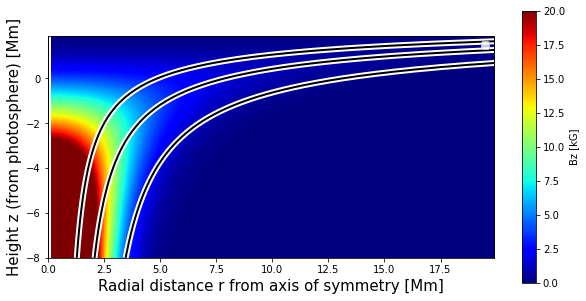

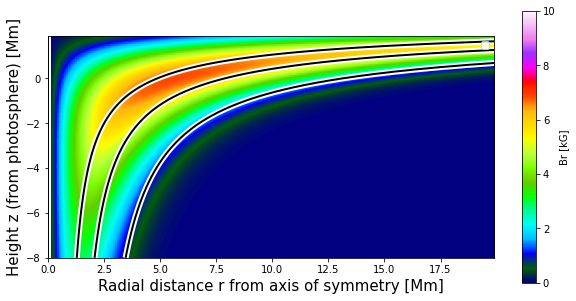

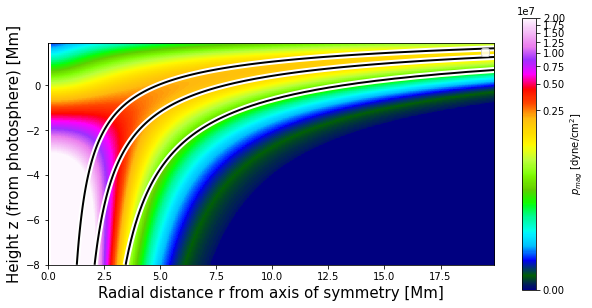

In [483]:
# Evaluate Bz on a Cartesian grid in r-z
Nr = 200
Nz = 100
radius = (np.arange(Nr)*0.1) # Mm
height= (np.arange(Nz)*0.1 - 8) # Mm

height, radius = np.meshgrid(height, radius)

Bz_array = Bz_func(radius, height)
Br_array = Br_func(radius, height)
flux_array = flux_func(radius, height)
flux_array = flux_func(radius, height)
Lz_array = Lz_func(radius, height)
Lr_array = Lr_func(radius, height)
# Magnetic pressure
pB_array = (Bz_array**2+Br_array**2)/8./np.pi

# Plot cross-sectional profiles
extent=(radius.min(),radius.max(), height.min(), height.max())
plt.figure(figsize=(10,5))
plt.imshow(Bz_array.T/1e3, cmap='jet', extent=extent, vmin=0,vmax=20, origin='lower')
plt.colorbar(label='Bz [kG]')

plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='k', 
            extent=extent, linewidths=2,alpha=1.)

plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

plt.figure(figsize=(10,5))
plt.imshow(Br_array.T/1e3, cmap='gist_ncar', extent=extent, vmin=0, vmax=10, origin='lower')
plt.colorbar(label='Br [kG]')
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='k', 
            extent=extent, linewidths=2,alpha=1.)


plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

plt.figure(figsize=(10,5))
plt.imshow(pB_array.T, cmap='gist_ncar', extent=extent, 
           origin='lower', norm=colors.PowerNorm(0.2,vmin=1e-2,vmax=2e7))
plt.colorbar(label='$p_{mag}$ [dyne/cm$^2$]')
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='k', 
            extent=extent, linewidths=2,alpha=1.)

plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

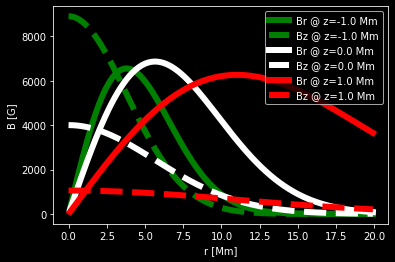

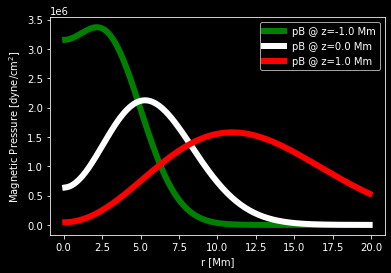

In [496]:
with plt.style.context('dark_background'):
    cs= ['green','white','red','gold']
    for i,d in enumerate([-30,-20,-10]):
        plt.plot(radius[:,d],Br_array[:,d], label='Br @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
        plt.plot(radius[:,d],Bz_array[:,d], "--", label='Bz @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
    plt.xlabel('r [Mm]')
    plt.ylabel('B [G]')
    plt.legend()
    plt.show()

    for i,d in enumerate([-30,-20,-10]):
        plt.plot(radius[:,d],pB_array[:,d], label='pB @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
    plt.xlabel('r [Mm]')
    plt.ylabel('Magnetic Pressure [dyne/cm$^2$]')
    plt.legend()
    plt.show()

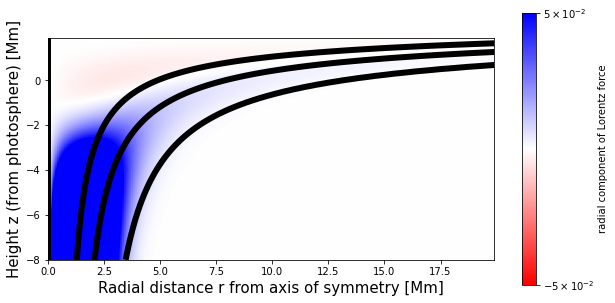

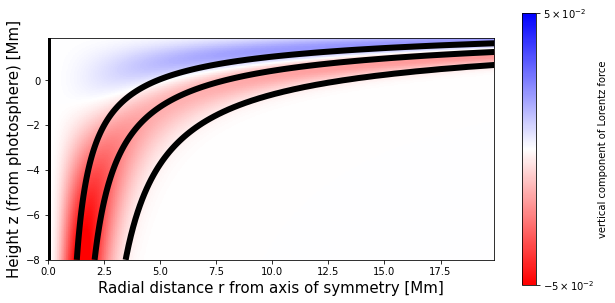

In [485]:
curlB_theta = sp.diff(Br,z)-sp.diff(Bz,r)
plt.figure(figsize=(10,5))

#NB: Division by 1e8 is needed to convert gradient in /Mm to /cm
plt.imshow(Lr_array.T/1e8, cmap='bwr_r', norm=colors.SymLogNorm(1e4,vmin=-5e-2,vmax=5e-2), extent=extent, origin='lower')
plt.colorbar(label='radial component of Lorentz force')
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='k', 
            extent=extent, linewidths=6,alpha=1)
plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(Lz_array.T/1e8, cmap='bwr_r', norm=colors.SymLogNorm(1e4,vmin=-5e-2,vmax=5e-2), extent=extent, origin='lower')
plt.colorbar(label='vertical component of Lorentz force')
plt.contour(radius, height,flux_array, levels=np.linspace(0,1e6,num=5),colors='k', 
            extent=extent, linewidths=6,alpha=1)
plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.show()

### Can we find a pressure distribution that balances the Lorentz force?

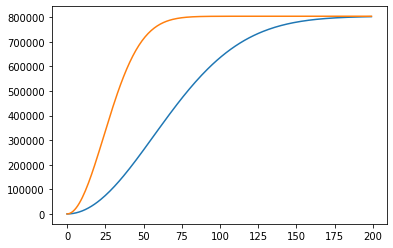

In [490]:
plt.plot(flux_array[:,-20])
plt.plot(flux_array[:,-50])

In [560]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

x = radius[:,0]
y = height[0,:]

p = figure(tooltips=[("r", "$x"), ("z", "$y"), ("value", "@image")], 
           x_range=(radius.min(),radius.max()),
           y_range=(height.min(), height.max()), 
           plot_height=400, plot_width=1000,
           title="Bz")

# must give a vector of image data for image parameter
p.image(image=[flux_array.T], x=radius.min(), y=height.min(), dw=radius.max()-radius.min(), 
        dh=(height.max()-height.min()), palette='Inferno9', level="image")
#p.x_range.range_padding = p.y_range.range_padding = 0
p.xaxis.axis_label = 'Radius [Mm]'
p.yaxis.axis_label = 'Height [Mm]'

p.grid.grid_line_width = 0.5
show(p)
#p.x_range.range_padding = p.y_range.range_padding = 0


Loading BokehJS ...

In [523]:
x, y

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
        14.3, 14.4, 14.5, 14.6, 14.7, 

In [504]:
height[:,0]

array([-8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8

In [501]:
p.y_rang


AttributeError: 'Figure' object has no attribute 'y_rang'

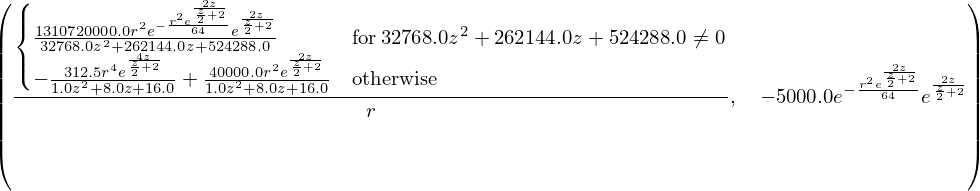